<a href="https://colab.research.google.com/github/megasiska86/Neural-Network-Repository/blob/master/fashion_mnist_ResNet18_50_152_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir fashion-mnist-master.zip

In [0]:
!rm -rf fashion-mnist-master.zip

In [0]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
629abc0f9a73c2897383a9178e8e38f7141be30d
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [0]:
%matplotlib inline 

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
transform = transforms.Compose([transforms.Resize(64), transforms.RandomHorizontalFlip(), transforms.Grayscale(num_output_channels=3),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=True, transform=transform,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=False, transform=transform,
                                       download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=0)
trainset1,validset = torch.utils.data.random_split(trainset, [50000,10000])
trainloader1=torch.utils.data.DataLoader(trainset1, batch_size=8,shuffle=True, num_workers=0)
validloader=torch.utils.data.DataLoader(validset, batch_size=8,shuffle=True, num_workers=0)

classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


0it [00:00, ?it/s]

26427392it [00:04, 5819232.92it/s]                              


Extracting fashion-mnist-master/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 39122.95it/s]                           
0it [00:00, ?it/s]

Extracting fashion-mnist-master/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:02, 1685428.80it/s]                            
0it [00:00, ?it/s]

Extracting fashion-mnist-master/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 15102.09it/s]            


Extracting fashion-mnist-master/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
#model=models.vgg16(pretrained=False, progress=False)
#model.features[0]=nn.Conv2d(1,64,kernel_size=3, stride=1, padding=1)
#model=model.to(device)
#print(model)

In [0]:
import torch.nn as nn
from torch.utils.model_zoo import load_url as load_state_dict_from_url

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.soft=nn.Softmax(1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

#Resnet18

In [0]:
def resnet18(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)
model18=resnet18().to(device)

In [0]:
optimizer=optim.SGD(model18.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
train_acc_list=[]
start_epoch=0
e=5

In [0]:
for epoch in range(start_epoch,20):
    #exp_lr_scheduler.step()
    model18.train()
    
    train_losses = []
    valid_losses = []
    model18.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model18(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 1600) % (1600 * 1600) == 0:
            print(i*10, '/ 50000')
            
    model18.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model18(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses.append(m_t_l)
    mean_valid_losses.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list.append(accuracy_v)
    train_acc_list.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model18.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'train loss': mean_train_losses,'train acc': train_acc_list, 'valid loss':mean_valid_losses, 'valid acc': valid_acc_list}, 'res18sch.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list),np.min(mean_train_losses)))

0 / 50000
epoch : 6, train loss : 0.3339, train acc : 87.90 valid loss : 0.2855, valid acc : 89.85%
0 / 50000
epoch : 7, train loss : 0.2706, train acc : 90.06 valid loss : 0.2624, valid acc : 90.26%
0 / 50000
epoch : 8, train loss : 0.2384, train acc : 91.26 valid loss : 0.2660, valid acc : 90.19%
0 / 50000
epoch : 9, train loss : 0.2160, train acc : 92.01 valid loss : 0.2381, valid acc : 90.88%
0 / 50000
epoch : 10, train loss : 0.1939, train acc : 92.71 valid loss : 0.2326, valid acc : 91.25%
0 / 50000
epoch : 11, train loss : 0.1773, train acc : 93.44 valid loss : 0.2425, valid acc : 91.15%
0 / 50000
epoch : 12, train loss : 0.1602, train acc : 94.04 valid loss : 0.2208, valid acc : 91.81%
0 / 50000
epoch : 13, train loss : 0.1465, train acc : 94.56 valid loss : 0.2699, valid acc : 91.15%
0 / 50000
epoch : 14, train loss : 0.1364, train acc : 94.87 valid loss : 0.2460, valid acc : 91.41%
0 / 50000
epoch : 15, train loss : 0.1226, train acc : 95.43 valid loss : 0.2286, valid acc : 9

In [0]:
checkpoint = torch.load('res18sch.pth')
model18.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
mean_train_losses = checkpoint['train loss']
train_acc_list=checkpoint['train acc']
mean_valid_losses = checkpoint['valid loss']
valid_acc_list=checkpoint['valid acc']

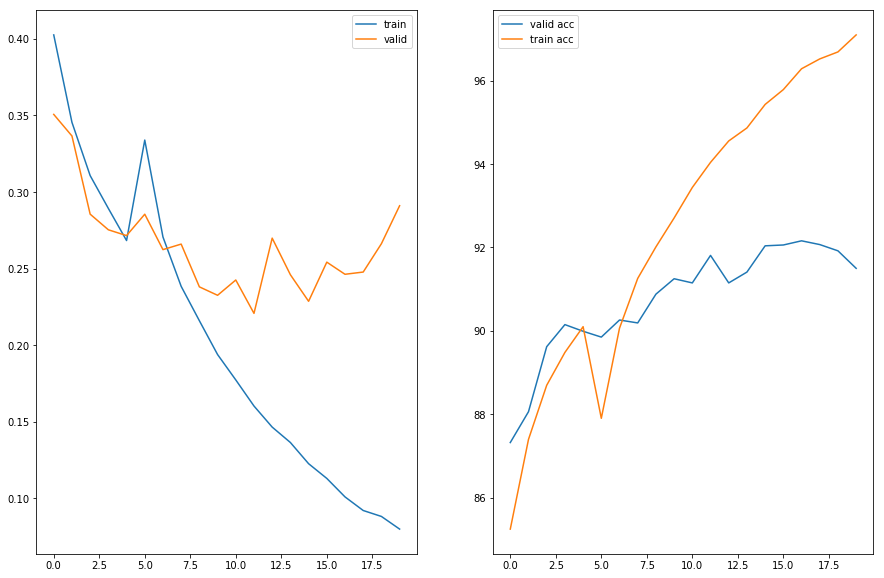

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list, label='valid acc')
ax2.plot(train_acc_list, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
test_acc_list=[]

In [0]:
for epoch in range (start_epoch):
    correct_te = 0
    total_te = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model18(images)
            _, predicted_v = torch.max(outputs.data, 1)
            correct_te += (predicted_v == labels).sum().item()
            total_te += labels.size(0)
    accuracy_te = 100*correct_te/total_te
    test_acc_list.append(accuracy_te)
    print('epoch: {0}, test accuracy: {1}%'.format(epoch+1,accuracy_te))

epoch: 1, test accuracy: 91.26%
epoch: 2, test accuracy: 91.24%
epoch: 3, test accuracy: 91.24%
epoch: 4, test accuracy: 91.21%
epoch: 5, test accuracy: 91.31%
epoch: 6, test accuracy: 91.12%
epoch: 7, test accuracy: 91.31%
epoch: 8, test accuracy: 91.23%
epoch: 9, test accuracy: 91.13%
epoch: 10, test accuracy: 91.2%
epoch: 11, test accuracy: 91.2%
epoch: 12, test accuracy: 91.28%
epoch: 13, test accuracy: 91.12%
epoch: 14, test accuracy: 91.42%
epoch: 15, test accuracy: 91.19%
epoch: 16, test accuracy: 91.33%
epoch: 17, test accuracy: 91.2%
epoch: 18, test accuracy: 91.2%
epoch: 19, test accuracy: 91.27%
epoch: 20, test accuracy: 91.23%


#Resnet50

In [0]:
def resnet50(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)
model50=resnet50().to(device)

In [0]:
optimizer1=optim.SGD(model50.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn1 = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
mean_train_losses1 = []
mean_valid_losses1 = []
valid_acc_list1 = []
train_acc_list1 =[]
start_epoch1=0
e1=5

In [0]:
for epoch in range(start_epoch1,20):
    #exp_lr_scheduler.step()
    model50.train()
    
    train_losses1 = []
    valid_losses1 = []
    model50.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer1.zero_grad()
        
        outputs = model50(images)
        loss = loss_fn1(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        if (i * 100) % (100 * 100) == 0:
            print(f'{i * 100} / 50000')
            
    model50.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model50(images)
            loss = loss_fn1(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses1.append(m_t_l)
    mean_valid_losses1.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list1.append(accuracy_v)
    train_acc_list1.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model50.state_dict(),'optimizer_state_dict': optimizer1.state_dict(), 'train loss': mean_train_losses1,'train acc': train_acc_list1, 'valid loss':mean_valid_losses1, 'valid acc': valid_acc_list1}, 'res50sch.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list1),np.min( mean_train_losses1)))

In [0]:
checkpoint = torch.load('res50sch.pth')
model50.load_state_dict(checkpoint['model_state_dict'])
optimizer1.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch1 = checkpoint['epoch']
mean_train_losses1 = checkpoint['train loss']
train_acc_list1=checkpoint['train acc']
mean_valid_losses1 = checkpoint['valid loss']
valid_acc_list1=checkpoint['valid acc']

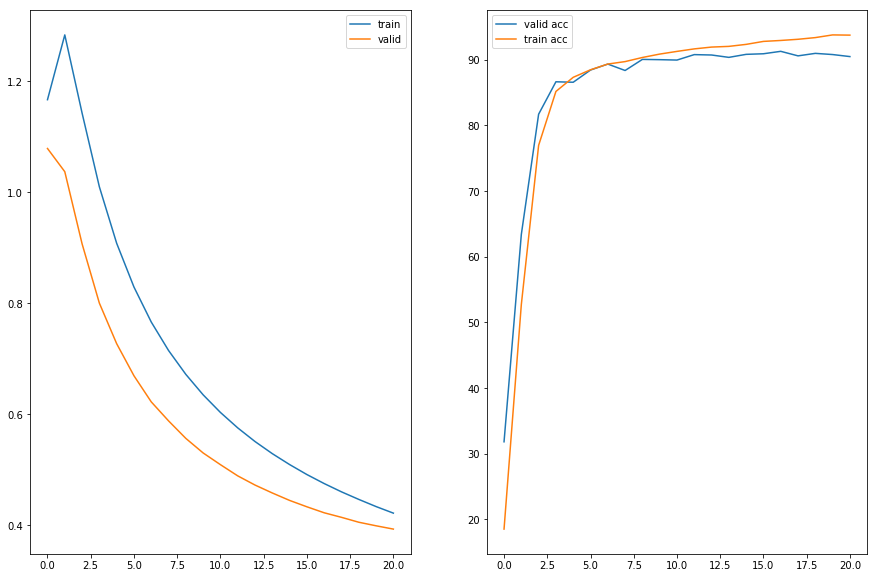

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses1, label='train')
ax1.plot(mean_valid_losses1, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list1, label='valid acc')
ax2.plot(train_acc_list1, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

#Resnet50 sch

In [0]:
optimizer1=optim.SGD(model50.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn1 = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.1)

In [0]:
mean_train_losses1 = []
mean_valid_losses1 = []
valid_acc_list1 = []
train_acc_list1 =[]
start_epoch1=0
e1=5

In [0]:
for epoch in range(start_epoch1,20):
    exp_lr_scheduler.step()
    model50.train()
    
    train_losses1 = []
    valid_losses1 = []
    model50.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer1.zero_grad()
        
        outputs = model50(images)
        loss = loss_fn1(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 100) % (100 * 100) == 0:
            print(f'{i * 100} / 50000')
            
    model50.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model50(images)
            loss = loss_fn1(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses1.append(m_t_l)
    mean_valid_losses1.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list1.append(accuracy_v)
    train_acc_list1.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model50.state_dict(),'optimizer_state_dict': optimizer1.state_dict(), 'train loss': mean_train_losses1,'train acc': train_acc_list1, 'valid loss':mean_valid_losses1, 'valid acc': valid_acc_list1}, 'res50sch.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list1),np.min( mean_train_losses1)))

0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 16, train loss : 0.3755, train acc : 95.54 valid loss : 0.3589, valid acc : 91.69%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 17, train loss : 0.3713, train acc : 95.87 valid loss : 0.3568, valid acc : 91.79%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 18, train loss : 0.3671, train acc : 96.06 valid loss : 0.3548, valid acc : 91.78%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 19, train loss : 0.3631, train acc : 96.19 valid loss : 0.3528, valid acc : 91.94%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 20, train loss : 0.3590, train acc : 96.56 valid loss : 0.3509, valid acc : 92.02%
best val acc: 92.03, best train loss: 0.3589940136902011


In [0]:
checkpoint = torch.load('res50sch.pth')
model50.load_state_dict(checkpoint['model_state_dict'])
optimizer1.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch1 = checkpoint['epoch']
mean_train_losses1 = checkpoint['train loss']
train_acc_list1=checkpoint['train acc']
mean_valid_losses1 = checkpoint['valid loss']
valid_acc_list1=checkpoint['valid acc']

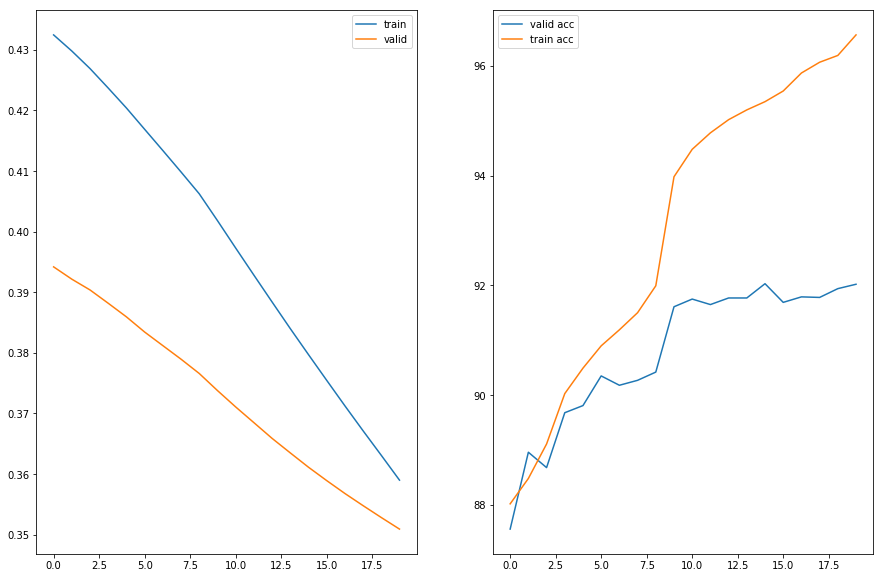

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses1, label='train')
ax1.plot(mean_valid_losses1, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list1, label='valid acc')
ax2.plot(train_acc_list1, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

#Resnet50 sch lr momen

In [0]:
optimizer1a=optim.SGD(model50.parameters(), lr=0.001, momentum=0.8, weight_decay=0.003)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn1a = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
exp_lr_scheduler1a = lr_scheduler.StepLR(optimizer1a, step_size=10, gamma=0.1)

In [0]:
mean_train_losses1a = []
mean_valid_losses1a = []
valid_acc_list1a = []
train_acc_list1a =[]
start_epoch1a=0
e1a=5

In [0]:
for epoch in range(start_epoch1a,20):
    exp_lr_scheduler1a.step()
    model50.train()
    
    train_losses = []
    valid_losses = []
    model50.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer1a.zero_grad()
        
        outputs = model50(images)
        loss = loss_fn1a(outputs, labels)
        loss.backward()
        optimizer1a.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 1500) % (1500* 1500) == 0:
            print(f'{i * 10} / 50000')
            
    model50.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model50(images)
            loss = loss_fn1a(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses1a.append(m_t_l)
    mean_valid_losses1a.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list1a.append(accuracy_v)
    train_acc_list1a.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model50.state_dict(),'optimizer_state_dict': optimizer1a.state_dict(), 'train loss': mean_train_losses1a,'train acc': train_acc_list1a, 'valid loss':mean_valid_losses1a, 'valid acc': valid_acc_list1a}, 'res50schwm.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list1a),np.min( mean_train_losses1a)))

0 / 50000
15000 / 50000
30000 / 50000
45000 / 50000
60000 / 50000
epoch : 1, train loss : 0.6819, train acc : 75.75 valid loss : 0.5595, valid acc : 79.64%
0 / 50000
15000 / 50000
30000 / 50000
45000 / 50000
60000 / 50000
epoch : 2, train loss : 0.5209, train acc : 81.08 valid loss : 0.4633, valid acc : 83.30%
0 / 50000
15000 / 50000
30000 / 50000
45000 / 50000
60000 / 50000
epoch : 3, train loss : 0.4465, train acc : 83.74 valid loss : 0.4390, valid acc : 83.72%
0 / 50000
15000 / 50000
30000 / 50000
45000 / 50000
60000 / 50000
epoch : 4, train loss : 0.4067, train acc : 85.13 valid loss : 0.3903, valid acc : 86.14%
0 / 50000
15000 / 50000
30000 / 50000
45000 / 50000
60000 / 50000
epoch : 5, train loss : 0.3726, train acc : 86.42 valid loss : 0.4249, valid acc : 84.59%
0 / 50000
15000 / 50000
30000 / 50000
45000 / 50000
60000 / 50000
epoch : 6, train loss : 0.3449, train acc : 87.41 valid loss : 0.3829, valid acc : 86.21%
0 / 50000
15000 / 50000
30000 / 50000
45000 / 50000
60000 / 5000

In [0]:
checkpoint = torch.load('res50schwm.pth')
model50.load_state_dict(checkpoint['model_state_dict'])
optimizer1a.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch1a = checkpoint['epoch']
mean_train_losses1a = checkpoint['train loss']
train_acc_list1a=checkpoint['train acc']
mean_valid_losses1a = checkpoint['valid loss']
valid_acc_list1a=checkpoint['valid acc']

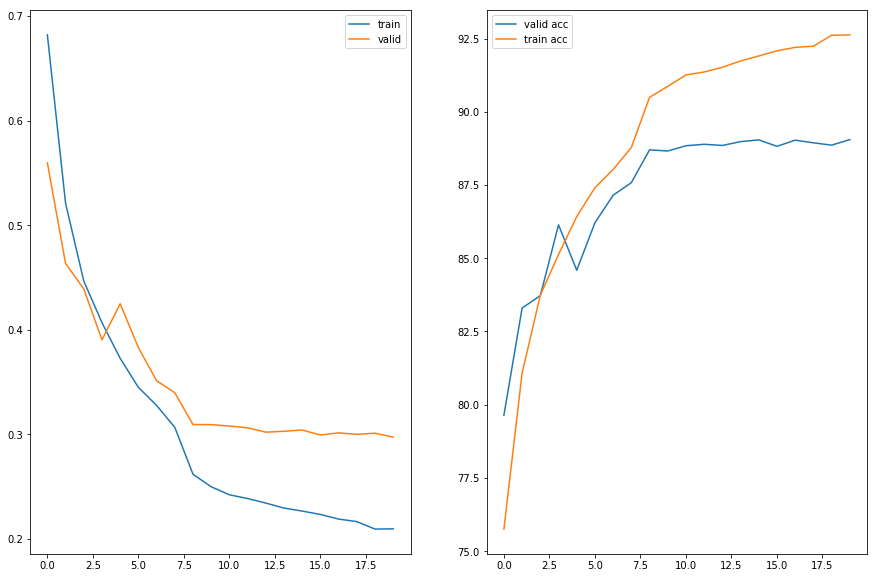

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses1a, label='train')
ax1.plot(mean_valid_losses1a, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list1a, label='valid acc')
ax2.plot(train_acc_list1a, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
test_acc_list1a=[]

In [0]:
for epoch in range (start_epoch1a):
    correct_te = 0
    total_te = 0
    model50.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model50(images)
            _, predicted_te = torch.max(outputs.data, 1)
            correct_te += (predicted_te == labels).sum().item()
            total_te += labels.size(0)
    accuracy_te = 100*correct_te/total_te
    test_acc_list1a.append(accuracy_te)
    print('epoch: {0}, test accuracy: {1}%'.format(epoch+1,accuracy_te))
print('rata2 : {}'.format(np.mean(test_acc_list1a)))

epoch: 1, test accuracy: 88.55%
epoch: 2, test accuracy: 88.5%
epoch: 3, test accuracy: 88.17%
epoch: 4, test accuracy: 88.32%
epoch: 5, test accuracy: 88.27%
epoch: 6, test accuracy: 88.34%
epoch: 7, test accuracy: 88.31%
epoch: 8, test accuracy: 88.4%
epoch: 9, test accuracy: 88.14%
epoch: 10, test accuracy: 88.6%
epoch: 11, test accuracy: 88.37%
epoch: 12, test accuracy: 88.3%
epoch: 13, test accuracy: 88.26%
epoch: 14, test accuracy: 88.41%
epoch: 15, test accuracy: 88.15%
epoch: 16, test accuracy: 88.33%
epoch: 17, test accuracy: 88.44%
epoch: 18, test accuracy: 88.33%
epoch: 19, test accuracy: 88.24%
epoch: 20, test accuracy: 88.22%
rata2 : 88.33250000000001


#weight decay 0.04

In [0]:
optimizer1b=optim.SGD(model50.parameters(), lr=0.001, momentum=0.8, weight_decay=0.004)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn1b = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
exp_lr_scheduler1b = lr_scheduler.StepLR(optimizer1b, step_size=10, gamma=0.1)

In [0]:
mean_train_losses1b = []
mean_valid_losses1b = []
valid_acc_list1b = []
train_acc_list1b =[]
start_epoch1b =0
e1b =5

In [0]:
for epoch in range(start_epoch1b,20):
    exp_lr_scheduler1b.step()
    model50.train()
    
    train_losses = []
    valid_losses = []
    model50.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer1b.zero_grad()
        
        outputs = model50(images)
        loss = loss_fn1b(outputs, labels)
        loss.backward()
        optimizer1b.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 100) % (100 * 100) == 0:
            print(f'{i * 100} / 50000')
            
    model50.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model50(images)
            loss = loss_fn1b(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses1b.append(m_t_l)
    mean_valid_losses1b.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list1b.append(accuracy_v)
    train_acc_list1b.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model50.state_dict(),'optimizer_state_dict': optimizer1b.state_dict(), 'train loss': mean_train_losses1b,'train acc': train_acc_list1b, 'valid loss':mean_valid_losses1b, 'valid acc': valid_acc_list1b}, 'res50schwm.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list1b),np.min( mean_train_losses1b)))

0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 1, train loss : 2.2672, train acc : 17.87 valid loss : 2.0020, valid acc : 28.29%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 2, train loss : 1.4747, train acc : 50.27 valid loss : 1.0518, valid acc : 64.74%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 3, train loss : 0.7615, train acc : 74.28 valid loss : 0.4871, valid acc : 82.24%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 4, train loss : 0.4494, train acc : 83.60 valid loss : 0.4118, valid acc : 85.29%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 5, train loss : 0.3772, train acc : 86.40 valid loss : 0.3531, valid acc : 87.00%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000
epoch : 6, train loss : 0.3423, train acc : 87.50 valid loss : 0.3436, valid acc : 87.36%
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 5000

In [0]:
checkpoint = torch.load('res50schwm.pth')
model50.load_state_dict(checkpoint['model_state_dict'])
optimizer1b.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch1b = checkpoint['epoch']
mean_train_losses1b = checkpoint['train loss']
train_acc_list1b=checkpoint['train acc']
mean_valid_losses1b = checkpoint['valid loss']
valid_acc_list1b=checkpoint['valid acc']

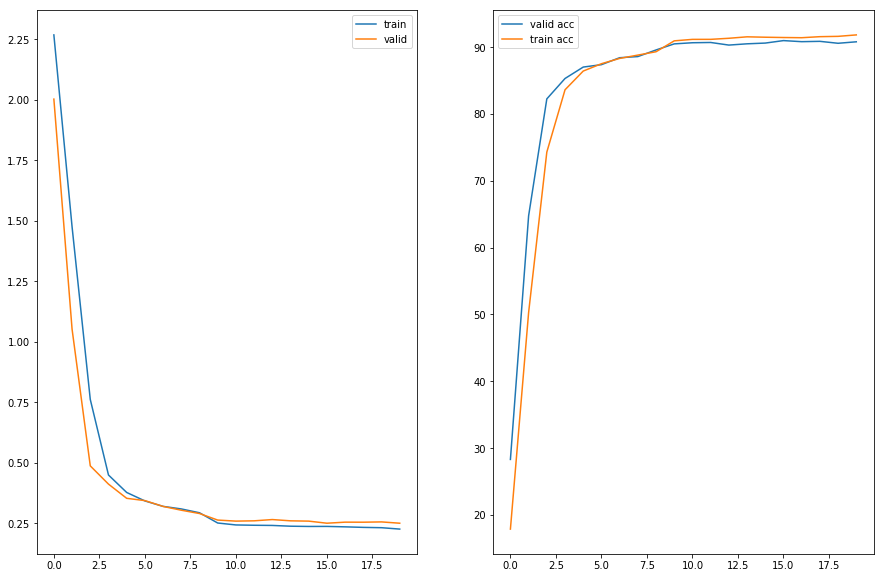

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses1b, label='train')
ax1.plot(mean_valid_losses1b, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list1b, label='valid acc')
ax2.plot(train_acc_list1b, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

#ResNet101

In [0]:
def resnet101(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)
model101=resnet101().to(device)

In [0]:
#optimizer2=optim.SGD(model101.parameters(), lr=0.001, momentum=0.8)
optimizer2 = torch.optim.Adam(model101.parameters(), lr=0.001)
loss_fn2 = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#loss_fn2 = nn.MSELoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer2, step_size=2, gamma=0.01)

In [0]:
mean_train_losses2 = []
mean_valid_losses2 = []
valid_acc_list2 = []
train_acc_list2=[]
start_epoch2=0
e2=5

In [0]:
for epoch in range(start_epoch2,10):
    exp_lr_scheduler.step()
    model101.train()
    
    train_losses = []
    valid_losses = []
    #model101.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer2.zero_grad()
        
        outputs = model101(images)
        loss = loss_fn2(outputs, labels)
        loss.backward()
        optimizer2.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if i%8000==0:
            print(i)

            
    #model101.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model101(images)
            loss = loss_fn2(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses2.append(m_t_l)
    mean_valid_losses2.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list2.append(accuracy_v)
    train_acc_list2.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model101.state_dict(),'optimizer_state_dict': optimizer2.state_dict(), 'train loss': mean_train_losses2,'train acc': train_acc_list2, 'valid loss':mean_valid_losses2, 'valid acc': valid_acc_list2}, 'resnet101.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list2),np.min(mean_train_losses2)))

epoch : 6, train loss : 0.4847, train acc : 82.35 valid loss : 0.5069, valid acc : 81.53%
epoch : 7, train loss : 0.4823, train acc : 82.59 valid loss : 0.5033, valid acc : 82.07%
epoch : 8, train loss : 0.4815, train acc : 82.59 valid loss : 0.5120, valid acc : 81.29%
epoch : 9, train loss : 0.4771, train acc : 82.54 valid loss : 0.5078, valid acc : 81.58%
epoch : 10, train loss : 0.4818, train acc : 82.48 valid loss : 0.5020, valid acc : 81.94%
best val acc: 82.07, best train loss: 0.47712267370224


In [0]:
!cp '/content/drive/My Drive/Colab Notebooks/resnet101.pth' '/content/resnet101.pth'

In [0]:
checkpoint = torch.load('resnet101.pth')
model101.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch2 = checkpoint['epoch']
mean_train_losses2 = checkpoint['train loss']
train_acc_list2=checkpoint['train acc']
mean_valid_losses2 = checkpoint['valid loss']
valid_acc_list2=checkpoint['valid acc']

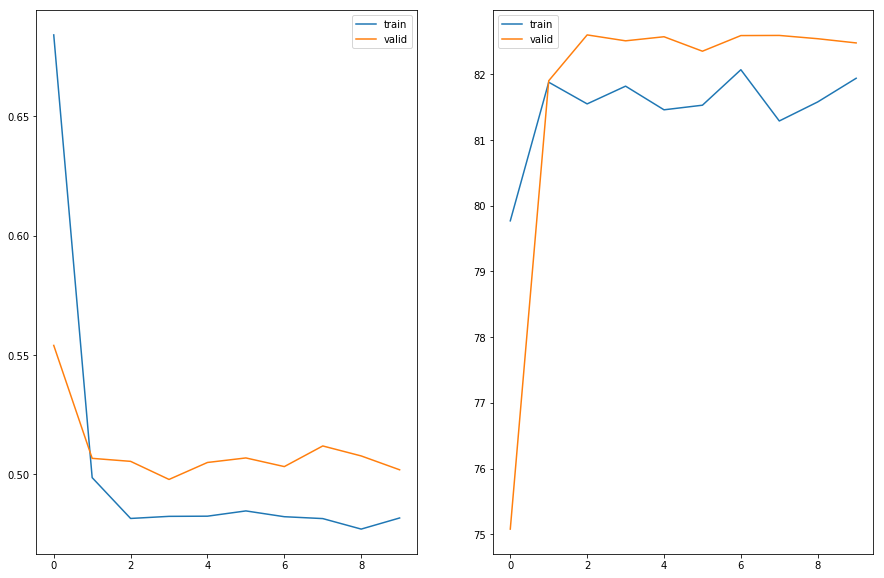

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses2, label='train')
ax1.plot(mean_valid_losses2, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list2, label='valid acc')
ax2.plot(train_acc_list2, label='train acc')
ax2.legend(lines, labels, loc='best')

In [0]:
test_acc_list2=[]

In [0]:
for epoch in range (start_epoch2):
    correct_te = 0
    total_te = 0
    model101.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model101(images)
            _, predicted_te = torch.max(outputs.data, 1)
            correct_te += (predicted_te == labels).sum().item()
            total_te += labels.size(0)
    accuracy_te = 100*correct_te/total_te
    test_acc_list2.append(accuracy_te)
    print('epoch: {0}, test accuracy: {1}%'.format(epoch+1,accuracy_te))
print('rata2 : {}'.format(np.mean(test_acc_list2)))

epoch: 1, test accuracy: 82.98%
epoch: 2, test accuracy: 82.92%
epoch: 3, test accuracy: 82.97%
epoch: 4, test accuracy: 82.96%
epoch: 5, test accuracy: 82.99%
epoch: 6, test accuracy: 83.01%
epoch: 7, test accuracy: 83.05%
epoch: 8, test accuracy: 83.11%
epoch: 9, test accuracy: 83.01%
epoch: 10, test accuracy: 83.06%
rata2 : 83.88916666666667


#Resnet152

In [0]:
def resnet152(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)
model152=resnet152().to(device)

In [0]:
#optimizer3=optim.SGD(model152.parameters(), lr=0.00001)
optimizer3 = torch.optim.Adam(model152.parameters(), lr=0.00001)
loss_fn3 = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer3, step_size=2, gamma=0.1)

In [0]:
mean_train_losses3 = []
mean_valid_losses3 = []
valid_acc_list3 = []
train_acc_list3=[]
start_epoch3=0
e3=5

In [0]:
for epoch in range(start_epoch3,20):
    exp_lr_scheduler.step()
    model152.train()
    
    train_losses = []
    valid_losses = []
    model152.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
                
        optimizer3.zero_grad()
        
        outputs = model152(images)
        loss = loss_fn3(outputs, labels)
        loss.backward()
        optimizer3.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
               
        if (i * 1600) % (1600 * 1600) == 0:
            print(f'{i * 10} / 50000')
            
    model152.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model152(images)
            loss = loss_fn3(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses3.append(m_t_l)
    mean_valid_losses3.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list3.append(accuracy_v)
    train_acc_list3.append(accuracy_t)
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model152.state_dict(),'optimizer_state_dict': optimizer3.state_dict(), 'train loss': mean_train_losses3,'train acc': train_acc_list3, 'valid loss':mean_valid_losses3, 'valid acc': valid_acc_list3}, 'resnet152.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f} valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list3),np.min(mean_train_losses3)))

0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
epoch : 2, train loss : 0.3194, train acc : 87.92 valid loss : 0.3131, valid acc : 88.48%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
epoch : 3, train loss : 0.2899, train acc : 88.97 valid loss : 0.3084, valid acc : 88.39%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
epoch : 4, train loss : 0.2678, train acc : 89.86 valid loss : 0.2922, valid acc : 89.27%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
epoch : 5, train loss : 0.2503, train acc : 90.63 valid loss : 0.2864, valid acc : 89.54%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
epoch : 6, train loss : 0.2353, train acc : 91.09 valid loss : 0.2831, valid acc : 89.46%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
epoch : 7, train loss : 0.2207, train acc : 91.72 valid loss : 0.2814, valid acc : 89.74%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
epoch : 8, train loss : 0.2084, train acc : 92.12 valid loss : 0.2798, valid acc : 89.83%
0 / 50

KeyboardInterrupt: ignored

In [0]:
checkpoint = torch.load('resnet152.pth')
model152.load_state_dict(checkpoint['model_state_dict'])
optimizer3.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch3 = checkpoint['epoch']
mean_train_losses3 = checkpoint['train loss']
train_acc_list3=checkpoint['train acc']
mean_valid_losses3 = checkpoint['valid loss']
valid_acc_list3=checkpoint['valid acc']

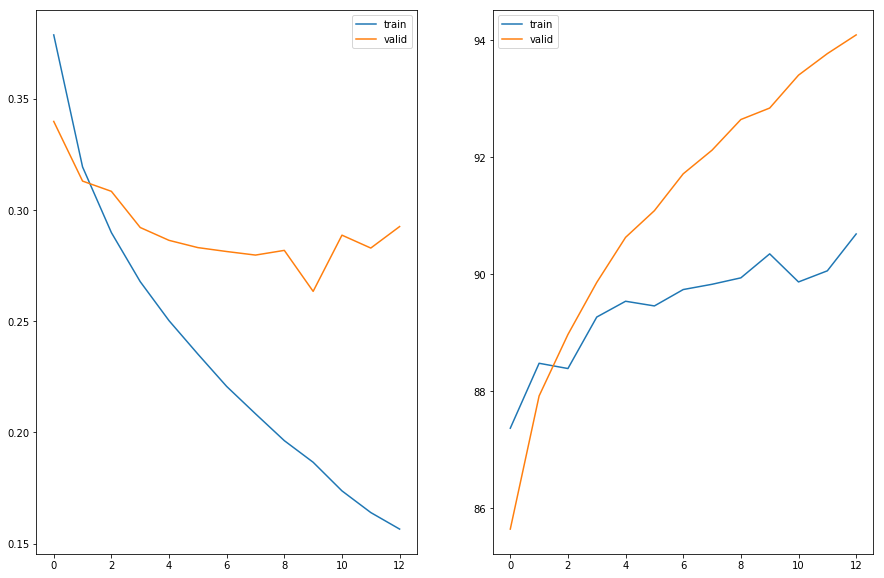

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses3, label='train')
ax1.plot(mean_valid_losses3, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list3, label='valid acc')
ax2.plot(train_acc_list3, label='train acc')
ax2.legend(lines, labels, loc='best')

In [0]:
test_acc_list3=[]

In [13]:
for epoch in range (start_epoch3):
    correct_te = 0
    total_te = 0
    model152.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model152(images)
            _, predicted_te = torch.max(outputs.data, 1)
            correct_te += (predicted_te == labels).sum().item()
            total_te += labels.size(0)
    accuracy_te = 100*correct_te/total_te
    test_acc_list3.append(accuracy_te)
    print('epoch: {0}, test accuracy: {1}%'.format(epoch+1,accuracy_te))
print('rata2 : {}'.format(np.mean(test_acc_list3)))

epoch: 1, test accuracy: 90.43%
epoch: 2, test accuracy: 90.39%
epoch: 3, test accuracy: 90.24%
epoch: 4, test accuracy: 90.62%
epoch: 5, test accuracy: 90.25%
epoch: 6, test accuracy: 90.43%
epoch: 7, test accuracy: 90.04%
epoch: 8, test accuracy: 90.52%
epoch: 9, test accuracy: 90.42%
epoch: 10, test accuracy: 90.41%
epoch: 11, test accuracy: 90.15%
epoch: 12, test accuracy: 90.33%
epoch: 13, test accuracy: 90.39%


NameError: ignored

In [7]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/resnet152.pth' '/content/drive/My Drive/Colab Notebooks'

In [0]:
!cp '/content/drive/My Drive/Colab Notebooks/resnet152.pth' '/content/resnet152.pth'